<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Modeling-an-entraining-cloud-updraft" data-toc-modified-id="Modeling-an-entraining-cloud-updraft-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Modeling an entraining cloud updraft</a></span><ul class="toc-item"><li><span><a href="#Find-the-derivatives-wrt-time-of-each-of-the-4-variables" data-toc-modified-id="Find-the-derivatives-wrt-time-of-each-of-the-4-variables-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Find the derivatives wrt time of each of the 4 variables</a></span></li><li><span><a href="#Find-the-buoyancy-from-the-cloud-and-environment-$\theta_e$-and-$r_T$" data-toc-modified-id="Find-the-buoyancy-from-the-cloud-and-environment-$\theta_e$-and-$r_T$-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Find the buoyancy from the cloud and environment $\theta_e$ and $r_T$</a></span></li><li><span><a href="#Integrator" data-toc-modified-id="Integrator-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Integrator</a></span></li><li><span><a href="#Read-in-a-sounding-to-set-the-environment" data-toc-modified-id="Read-in-a-sounding-to-set-the-environment-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Read in a sounding to set the environment</a></span></li><li><span><a href="#Do-the-integration-for-diffrerent-entrainment-rates" data-toc-modified-id="Do-the-integration-for-diffrerent-entrainment-rates-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Do the integration for diffrerent entrainment rates</a></span></li><li><span><a href="#now-loop-over-4-entrainmnt-rates-and-add-the-results-as-new-columns" data-toc-modified-id="now-loop-over-4-entrainmnt-rates-and-add-the-results-as-new-columns-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>now loop over 4 entrainmnt rates and add the results as new columns</a></span></li><li><span><a href="#plot-the-thetae-for-all-runs-to-check----generate-the-column-name-from-the-entrainment-rate" data-toc-modified-id="plot-the-thetae-for-all-runs-to-check----generate-the-column-name-from-the-entrainment-rate-1.7"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>plot the thetae for all runs to check -- generate the column name from the entrainment rate</a></span></li><li><span><a href="#Put-all-runs-on-the-same-skewT-plot" data-toc-modified-id="Put-all-runs-on-the-same-skewT-plot-1.8"><span class="toc-item-num">1.8&nbsp;&nbsp;</span>Put all runs on the same skewT plot</a></span></li></ul></li></ul></div>

# Modeling an entraining cloud updraft

This notebook shows how to calculate the time evolution of four variables:

\[velocity, height, $\theta_{ecld}$, $r_{Tcld}$ \]

in a rising cloud

In [1]:
"""
model a bulk entraining plume with constant entrainment rate
"""
import numpy as np
import pandas as pd
from pprint import pformat
from a405.thermo.constants import constants as c
from a405.thermo.thermlib import find_Tmoist,find_thetaep,find_rsat,tinvert_thetae
from scipy.interpolate import interp1d
from a405.soundings.wyominglib import write_soundings, read_soundings
import json
from matplotlib import pyplot as plt


from scipy.integrate import ode
import matplotlib.pyplot as plt
from a405.skewT.nudge import nudge

## Find the derivatives wrt time of each of the 4 variables

See [entrain.pdf](http://clouds.eos.ubc.ca/~phil/courses/atsc405/docs/entrain.pdf)

In [2]:
def derivs(t, y, entrain_rate, interpTenv, interpTdEnv, interpPress):
    """Function that computes derivative vector for ode integrator
       see http://clouds.eos.ubc.ca/~phil/courses/atsc405/docs/entrain.pdf for equations

    Parameters
    ----------
    
    t: float
       time (s)
    y: vector
       4-vector containing wvel (m/s), height (m), thetae (K), rT (kg/kg)
    entrain_rate: float
                  1/m dm/dt (s-1)
    interpTenv: func
                interp1d function for environmental temperature T(z) 
    interpTdEnv: func
                interp1d function for environmental dewpoint temperature Td(z)
    interpPress: func
                interp1d function for presusure  p(z)

    Returns
    -------

    yp: vector
       4-vector containing time derivatives of wvel (m/s^2), height (m/s), thetae (K/s), rT (kg/kg/s)
    """
    yp = np.zeros((4,1),dtype=np.float)
    velocity = y[0]
    height = y[1]
    thetae_cloud = y[2]
    rT_cloud = y[3]
    #yp[0] is the acceleration, in this case the buoyancy 
    yp[0] = calcBuoy(height, thetae_cloud, interpTenv, interpTdEnv, interpPress)
    press = interpPress(height)*100. #Pa
    Tdenv = interpTdEnv(height) + c.Tc #K
    Tenv = interpTenv(height) + c.Tc #K
    rTenv = find_rsat(Tdenv, press) #kg/kg
    thetaeEnv = find_thetaep(Tdenv, Tenv, press)
    #yp[1] is the rate of change of height
    yp[1] = velocity
    #yp[2] is the rate of change of thetae_cloud
    yp[2] = entrain_rate*(thetaeEnv - thetae_cloud)
    #yp[3] is the rate of change of rT_cloud
    yp[3] = entrain_rate*(rTenv - rT_cloud)
    return yp

## Find the buoyancy from the cloud and environment $\theta_e$ and $r_T$

In [3]:
def calcBuoy(height, thetae0, interpTenv, interpTdEnv, interpPress):
    """function to calculate buoyant acceleration for an ascending saturated parcel
       this version neglects liquid water loading
    
    Parameters
    ----------
    
    height: float
            parcel height (m)
    thetae0: float
            parcel thetae (K)

    interpTenv: func
                interp1d function for environmental temperature T(z) 
    interpTdEnv: func
                interp1d function for environmental dewpoint temperature Td(z)
    interpPress: func
                interp1d function for presusure  p(z)

    Returns
    -------

    buoy: float
          buoyancy (m/s/s)
    """
    #input: height (m), thetae0 (K), plus function handles for
    #T,Td, press soundings
    #output: Bout = buoyant acceleration in m/s^2
    #neglect liquid water loading in the virtual temperature
    
    press=interpPress(height)*100.#%Pa
    Tcloud=find_Tmoist(thetae0,press) #K
    rvcloud=find_rsat(Tcloud,press); #kg/kg
    Tvcloud=Tcloud*(1. + c.eps*rvcloud)
    Tenv=interpTenv(height) + c.Tc
    Tdenv=interpTdEnv(height) + c.Tc
    rvenv=find_rsat(Tdenv,press); #kg/kg
    Tvenv=Tenv*(1. + c.eps*rvenv)
    TvDiff=Tvcloud - Tvenv
    buoy = c.g0*(TvDiff/Tvenv)
    return buoy



## Integrator 

Use http://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.ode.html to integrate our system of 4 odes 

In [4]:
def integ_entrain(df_sounding,entrain_rate):
    """integrate an ascending parcel given a constant entrainment rate
       this version hardwired to start parcel at 800 hPa with cloud base
       values of environment at 900 hPa

    Parameters
    ----------

    df_sounding: pandas dataframe 
               : cloumns are temperature, dewpoint, height, press

    entrain_rate: float
                  1/m dm/dt (s-1)

    Returns
    -------

    df_out: dataframe
          dataframe containing wvel (m/s) ,cloud_height (m) , thetae (K), rT (kg/kg) for assending parcel

   interpPress: func
              interp1d function for presusure  p(z) (used for plotting)
    """
    press = df_sounding['pres'].values
    height = df_sounding['hght'].values
    temp = df_sounding['temp'].values
    dewpoint = df_sounding['dwpt'].values
    envHeight= nudge(height)

    interpTenv = interp1d(envHeight,temp)
    interpTdEnv = interp1d(envHeight,dewpoint)
    interpPress = interp1d(envHeight,press)
    #
    # call this cloudbase
    #
    p900_level = len(press) - np.searchsorted(press[::-1],900.)
    thetaeVal=find_thetaep(dewpoint[p900_level] + c.Tc,temp[p900_level] + c.Tc,press[p900_level]*100.)
    rTcloud = find_rsat(dewpoint[p900_level] + c.Tc, press[p900_level]*100.)
    #
    # start parcel here
    #
    p800_level = len(press) - np.searchsorted(press[::-1],800.)
    height_800=height[p800_level]
    winit = 0.5 #initial velocity (m/s)
    yinit = [winit, height_800, thetaeVal, rTcloud]  
    tinit = 0  #seconds
    tfin = 2500  #seconds
    dt = 10   #seconds

    #want to integrate derivs using dopr15 runge kutta described at
    # http://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.ode.html
    #
    r = ode(derivs).set_integrator('dopri5')
    r.set_f_params(entrain_rate, interpTenv, interpTdEnv, interpPress)
    r.set_initial_value(yinit, tinit)
    
    #the while loop below  integrates every dt seconds
    #we stop tracking the parcel when the time runs out, or if the parcel stops moving/is desecnding
    #
    var_out = []
    time_out =[]
    while r.successful() and r.t < tfin and r.y[0] > 0:
        #find y at the next time step
        #(r.integrate(t) updates the fields r.y and r.t so that r.y = integral of derivs(t) and r.t = time 
        #where derivs is a vector with the variables to be integrated
        #
        # move ahead by dt
        #
        r.integrate(r.t+dt)
        #
        # stop if there is negative vertical velocity
        #
        if r.y[0] <= 0:
            break
        #
        #save values for dataframe
        #
        var_out.append(r.y)
        time_out.append(r.t)
    #
    # convert the output into a datafram
    #
    colnames=['wvel','cloud_height','thetae_cloud','rT_cloud']
    df_out=pd.DataFrame.from_records(var_out,columns=colnames)
    df_out['time'] = time_out
    return df_out,interpPress



## Read in a sounding to set the environment

In [5]:
def get_sounding(get_data=True,soundingdir='littlerock',soundingfile='littlerock.csv',
                 metafile='littlerock.json',values=None,the_time=None):
    """
    Parameters
    ----------
    
    get_data: bool
        set to False to read from an existing soundingfile
    soundingdir: string
        name of folder for retrieved soundings
    sondingfile: string
        name of csv file that holds sounding for this run
    metafile:  string
        name of json file that holds sounding metadata for this run
    values:  dict
        dictionary containing parameters needed by a405.soundings.wyominglib.write_soundings
    the_time: tuple
        (year, month, day, hour) tuple for sounding for current run
        
    Returns
    -------
    
    sounding: Dataframe
       pandas dataframe with sounding columns
    attributes: dict
       dictionary with sounding metadata
    """
    if get_data:
        if values is None:
            values=dict(region='naconf',year='2012',month='7',start='0100',
                        stop='3000',station='72340')
            the_time=(2012,7,17,0)
        write_soundings(values, soundingdir)
        soundings= read_soundings(soundingdir)
        sounding=soundings['sounding_dict'][the_time]
        sounding.to_csv(soundingfile)
        title_string=soundings['attributes']['header']
        index=title_string.find(' Observations at')
        location=title_string[:index]
        print(f'location: {location}')
        units=soundings['attributes']['units'].split(';')
        units_dict={}
        for count,var in enumerate(sounding.columns[1:]):
            units_dict[var]=units[count]
        soundings['attributes']['location']=location
        soundings['attributes']['units']=units
        soundings['attributes']['time']=the_time
        soundings['attributes']['history']='written by entraining_plume notebook'
        with open(metafile,'w') as outfile:
            json.dump(soundings['attributes'],outfile,indent=4)
        attributes=soundings['attributes']
    else:
        sounding = pd.read_csv(soundingfile)
        with open(metafile,'r') as infile:
            attributes=json.load(infile)
    return sounding,attributes



## Do the integration for diffrerent entrainment rates

To demonstrate how pandas dataframes work -- calculate the thetae, rT profiles for
different entrainment rates and add them as columns to a dataframe

In [26]:
df_sounding,attributes = get_sounding(get_data=False)
import copy
hPa2pa=1.e2

## create a new dataframe from the integrator output

keep only the height, thetae and rt columns of the 0 entrainment run

In [8]:
np.warnings.filterwarnings('ignore')
rate = 0.
df_zero_rate, interpPress=integ_entrain(df_sounding,rate)
#
# save the result in a new dataframe
#
df_output=copy.copy(df_zero_rate[['cloud_height','thetae_cloud','rT_cloud']])
cloud_press = interpPress(df_output['cloud_height'].values)
df_output['p0']=cloud_press
df_output.rename(columns={'thetae_cloud':'th_e0','rT_cloud':'rT_e0'},inplace=True)
df_output.head()

,cloud_height,th_e0,rT_e0,p0
0,2141.528504,351.855,0.015525,793.097340
1,2154.092386,351.855,0.015525,791.924711
2,2171.647975,351.855,0.015525,790.293818
3,2194.250759,351.855,0.015525,788.206773
4,2222.129471,351.855,0.015525,785.632571


## now loop over 4 entrainmnt rates and add the results as new columns

In [9]:
entrain_rate = [2.e-4,5.e-4,8.e-4,1.e-3]
colnames_press=['p2','p5','p8','p10']
colnames_temp =['th_e2','th_e5','th_e8','th_e10']
colnames_rT = ['rT_e2','rT_e5','rT_e8','rT_e10']
quads = zip(entrain_rate,colnames_press,colnames_temp,colnames_rT)
for rate, pname, tname, rTname in quads:
  df_result, interpPress=integ_entrain(df_sounding,rate)
  press=interpPress(df_output['cloud_height'])
  df_output[pname] = press
  df_output[tname]=df_result['thetae_cloud']
  df_output[rTname] = df_result['rT_cloud']
df_output.tail()

,cloud_height,th_e0,rT_e0,p0,p2,th_e2,rT_e2,p5,th_e5,rT_e5,p8,th_e8,rT_e8,p10,th_e10,rT_e10
47,15868.157861,351.855,0.015525,113.883814,113.883814,350.791297,0.014570,113.883814,349.248645,0.013283,113.883814,347.870833,0.012156,113.883814,347.025896,0.011484
48,16385.958079,351.855,0.015525,104.541262,104.541262,350.842567,0.014541,104.541262,349.278953,0.013217,104.541262,347.869882,0.012059,104.541262,347.020983,0.011370
49,16805.604916,351.855,0.015525,97.536032,97.536032,350.912853,0.014512,97.536032,349.368176,0.013151,97.536032,347.885418,0.011963,97.536032,347.025901,0.011257
50,17109.109681,351.855,0.015525,92.730105,92.730105,350.997345,0.014483,92.730105,349.516944,0.013085,92.730105,347.962947,0.011868,92.730105,347.046346,0.011145
51,17284.825484,351.855,0.015525,90.056526,90.056526,351.094581,0.014454,90.056526,349.701136,0.013020,90.056526,348.126016,0.011773,90.056526,347.121695,0.011034


## plot the thetae for all runs to check -- generate the column name from the entrainment rate

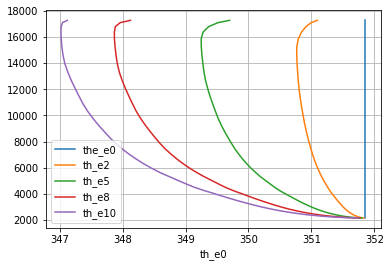

In [11]:
ax=df_output.plot('th_e0','cloud_height',label='the_e0',legend=False);
for rate in [2, 5, 8, 10]:
    tname = f'th_e{rate}'
    ax.plot(tname,'cloud_height',data=df_output,label=tname)
ax.legend()
ax.grid(True);

## Put all runs on the same skewT plot

First generate the plot

In [14]:
from a405.thermo.thermlib import convertSkewToTemp, convertTempToSkew
from a405.skewT.fullskew import makeSkewWet,find_corners,make_default_labels
def label_fun():
    """
    override the default rs labels with a tighter mesh
    """
    from numpy import arange
    #
    # get the default labels
    #
    tempLabels,rsLabels, thetaLabels, thetaeLabels = make_default_labels()
    #
    # change the temperature and rs grids
    #
    tempLabels = range(-40, 50, 2)
    rsLabels = [0.1, 0.25, 0.5, 1, 2, 3] + list(np.arange(4, 28, 2)) 
    return tempLabels,rsLabels, thetaLabels, thetaeLabels

In [15]:
skew=35.
triplets=zip(df_sounding['temp'],df_sounding['dwpt'],df_sounding['pres'])
xcoord_T=[]
xcoord_Td=[]
for a_temp,a_dew,a_pres in triplets:
    xcoord_T.append(convertTempToSkew(a_temp,a_pres,skew))
    xcoord_Td.append(convertTempToSkew(a_dew,a_pres,skew))

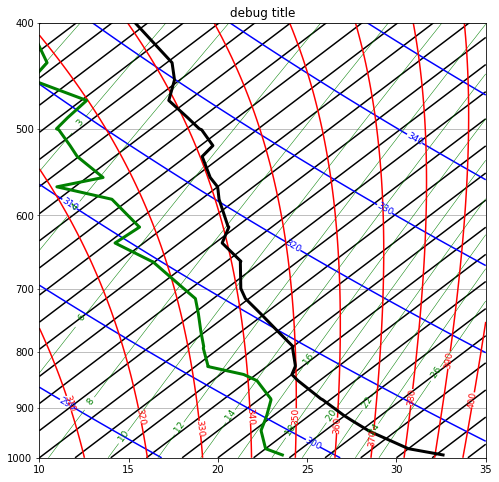

In [16]:
fig,ax =plt.subplots(1,1,figsize=(8,8))
corners = [10, 35]
skew=35
ax, skew = makeSkewWet(ax, corners=corners, skew=skew,label_fun=label_fun)
xcorners=find_corners(corners,skew=skew)
ax.set(xlim=xcorners,ylim=[1000,400]);
l1,=ax.plot(xcoord_T,df_sounding['pres'],color='k',label='temp')
l2,=ax.plot(xcoord_Td,df_sounding['pres'],color='g',label='dew')
[line.set(linewidth=3) for line in [l1,l2]];

## define a function that calculates the skewT, press coords for a rate

In [49]:
from a405.thermo.rootfinder import BracketError
def calc_xcoord_thetae(dataframe,rate,skew):
    """
    given a dataframe with columnes like: the_e8, rT_e8, p8
    calculate the temperature, pressure sounding for those columns
    by using tinvert_thetae on each row
    """
    thetae_col,rT_col,press_col= f'th_e{rate}',f'rT_e{rate}',f'p{rate}'
    thetae_sound=dataframe[thetae_col].values
    rT_sound=dataframe[rT_col].values
    press_sound=dataframe[press_col].values
    triplet = zip(thetae_sound,rT_sound,press_sound)
    xcoord_T = []
    press_coord = []
    for the_thetae,the_rT,the_press in triplet:
        try:
            temp,rv,rl = tinvert_thetae(the_thetae,the_rT,the_press*hPa2pa)
            xcoord_T.append(convertTempToSkew(temp - c.Tc,the_press,skew))
        except BracketError:
            xcoord_T.append(np.nan)
        press_coord.append(the_press)
    return xcoord_T,press_coord


## Now add each of these lines to the plot with skew=35

In [50]:
for rate in [2,5,8,10]:
    xcoord_T,the_press=calc_xcoord_thetae(df_output,rate,skew)
    l1,=ax.plot(xcoord_T,the_press,label=rate)

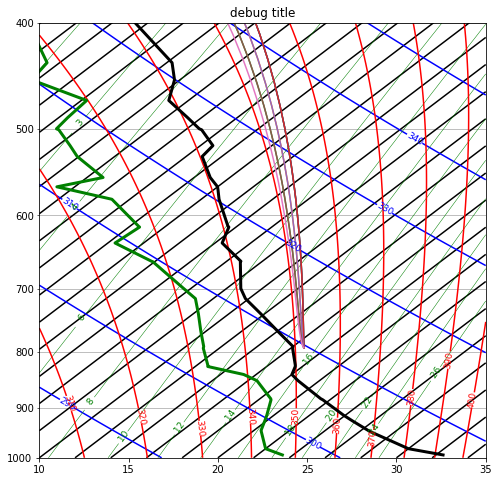

In [46]:
display(fig)